<div style="text-align:center; font-family: 'Arial', sans-serif; margin-top: 30px; background-color:#f5f7fa; padding:25px; border-radius:15px; box-shadow: 0 4px 10px rgba(0,0,0,0.1);">
    <h1 style="color:#2E8B57; font-size: 50px; margin-bottom: 10px;">Plant Disease Classifier</h1>
    <p style="color:#555; font-size: 20px; margin-bottom:5px;">by <strong>Seif Eldeen</strong></p>
    <p style="color:#333; font-size: 18px; max-width: 850px; margin:auto; line-height:1.5;">
        This project demonstrates a deep learning model based on <strong>Transfer Learning</strong> using architectures such as   <strong>MobileNetV3</strong> to classify plant leaf images into <strong>15 different disease categories</strong>.
        The dataset includes healthy and infected leaves from multiple plant species. The model was trained with advanced augmentation, early stopping, and fine-tuning to achieve high accuracy while preventing overfitting.
    </p>
    <hr style="width:50%; margin:auto; border:2px solid #2E8B57; margin-top:20px;">
</div>


<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">1) Importing Libraries</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        In this section, we import all the essential Python libraries for image preprocessing, visualization, and building our deep learning model using transfer learning for plant disease classification.
    </p>
</div>


In [1]:
!pip install split-folders

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import splitfolders
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.utils import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-10-20 00:24:09.713138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760919849.975816      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760919850.041429      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">2) Defining Constants</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        Here, we define important constants such as dataset paths, image size, batch size, and other parameters used throughout the training process to ensure consistency and easy configuration.
    </p>
</div>


In [3]:
IMAGES_FOLDERS_PATH = '/kaggle/input/plantdisease/PlantVillage'
OUTPUT_FOLDER = 'plantdisease_split'
BATCH_SIZE = 64
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
EPOCHS = 100

<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">3) Dataset Analysis</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        In this section, we perform an initial analysis of the dataset by visualizing sample images from each plant disease category.
        The function <strong>VisualizeClasses()</strong> dynamically loads and displays one example from each folder, showing the class name and image resolution to verify the dataset structure and consistency.
        Additionally, a random image is displayed alongside its resized version (224×224) to ensure correct preprocessing before training.
    </p>
</div>


Classes Number: 15


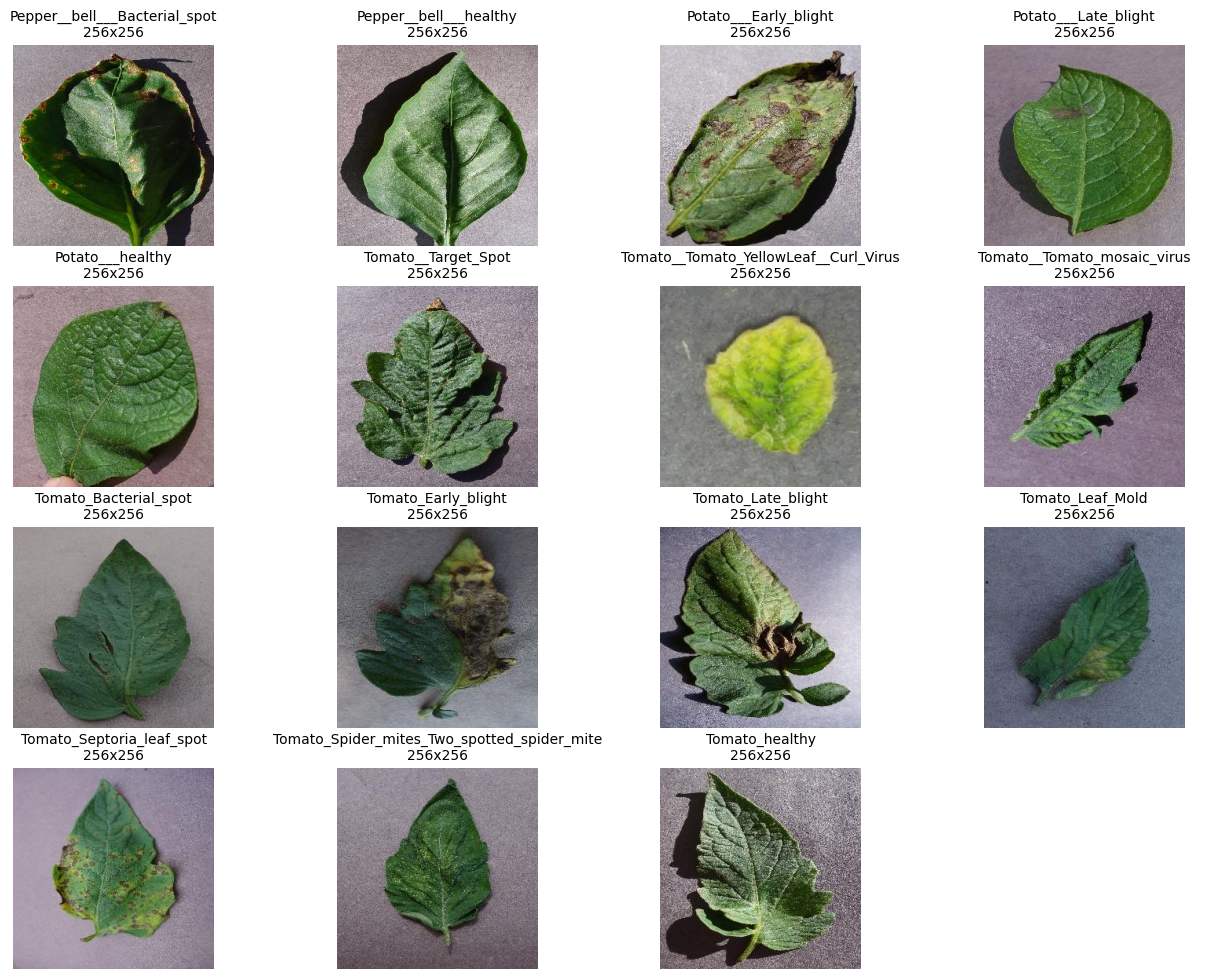

In [4]:
def VisualizeClasses(folders_path):
    # Get all class folders and sort them
    ClassesNames = os.listdir(folders_path)
    ClassesNames.sort(key=lambda x: (x.split('__')[0], x))
    
    # Display the total number of classes
    NUM_CLASSES = len(ClassesNames)
    print(f"Classes Number: {NUM_CLASSES}")
    
    # Prepare the grid for showing sample images
    cols = 4
    rows = (NUM_CLASSES + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
    axes = axes.flatten()
    
    # Show one sample image from each class
    for i, cat in enumerate(ClassesNames):
        ClassFolderPath = os.path.join(folders_path,cat)
        ImagesName = os.listdir(ClassFolderPath)
        img_path = os.path.join(ClassFolderPath,ImagesName[0])
        with Image.open(img_path) as img:
            width, height = img.size
        image = mpimg.imread(img_path)
        axes[i].imshow(image)
        axes[i].set_title(f"{cat}\n{width}x{height}", fontsize=10)
        axes[i].axis('off')
        
    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

# Call the function to visualize all classes
VisualizeClasses(IMAGES_FOLDERS_PATH)   



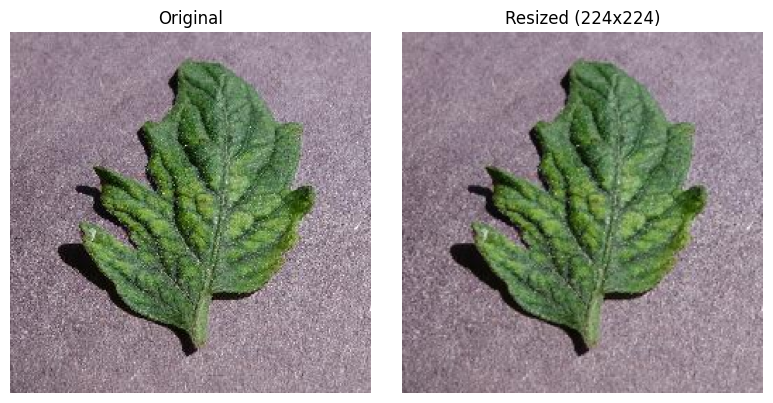

In [5]:
# Pick a random class folder
ClassesNames = os.listdir(IMAGES_FOLDERS_PATH)
random_class = random.choice(ClassesNames)
class_path = os.path.join(IMAGES_FOLDERS_PATH, random_class)

# Pick a random image from that class
images = os.listdir(class_path)
random_image = random.choice(images)
img_path = os.path.join(class_path, random_image)

# Open and resize the selected image to 224x224
with Image.open(img_path) as img:
    resized_img = img.resize((WIDTH, HEIGHT)) 

# Display the original and resized images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(mpimg.imread(img_path))
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(resized_img)
axes[1].set_title(f"Resized ({WIDTH}x{HEIGHT})")
axes[1].axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">4) Data Preparation</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        In this section, the dataset is split into <strong>training (80%)</strong> and <strong>validation (20%)</strong> sets using <strong>SplitFolders</strong>.
        To improve the model's generalization and prevent overfitting, <strong>data augmentation</strong> techniques such as rotation, zooming, shearing, and horizontal flipping are applied using the <strong>ImageDataGenerator</strong> class.
        All images are resized to <strong>224×224</strong> pixels and normalized through <strong>MobileNetV3-Large’s preprocessing function</strong>.
    </p>
</div>


In [6]:
# Split the dataset into training (80%) and validation (20%) folders
splitfolders.ratio(IMAGES_FOLDERS_PATH, output=OUTPUT_FOLDER, seed=42, ratio=(0.8, 0.2))


Copying files: 20639 files [03:20, 102.88 files/s]


In [7]:
# Define the training and validation dataset paths
TRAIN_FOLDER_PATH = '/kaggle/working/plantdisease_split/train'
VAL_FOLDER_PATH = '/kaggle/working/plantdisease_split/val'

# Data augmentation for training images (adds variations to improve generalization)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Apply MobileNetV3 preprocessing
    rotation_range=20, # Random rotations
    width_shift_range=0.2, # Horizontal shifts
    height_shift_range=0.2, # Vertical shifts
    shear_range=0.2, # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest' # Fill missing pixels after transformations
)
train_image_generator = train_datagen.flow_from_directory(
                                            TRAIN_FOLDER_PATH,
                                            target_size=(WIDTH, HEIGHT), # Resize all images to 224x224
                                            batch_size= BATCH_SIZE, # Number of images per batch
                                            class_mode='categorical') # Multi-class classification


# Validation images (no augmentation, only preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_image_generator = val_datagen.flow_from_directory(
                                            VAL_FOLDER_PATH,
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical')





Found 16504 images belonging to 15 classes.
Found 4134 images belonging to 15 classes.


In [8]:
class_names = list(val_image_generator.class_indices.keys()) 
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">5) Model Building</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        In this step, the <strong>MobileNetV3-Large</strong> architecture is used as the base model with pretrained <strong>ImageNet</strong> weights.
        The base model’s layers are frozen to retain the learned features during initial training.
        A <strong>Global Average Pooling</strong> layer is added to reduce spatial dimensions, followed by a <strong>Dense</strong> layer with 128 neurons and <strong>ReLU</strong> activation for deeper feature learning.
        A <strong>Dropout</strong> layer with a rate of 0.3 helps prevent overfitting.
        Finally, a <strong>Softmax</strong> output layer classifies images into the <strong>15 plant disease categories</strong>.
    </p>
</div>


In [9]:
# Load the MobileNetV3-Large model pre-trained on ImageNet (without the top classification layer)
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, CHANNELS))

# Freeze the base model layers to keep pretrained weights during initial training
base_model.trainable = False

# Build the new model on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(train_image_generator.num_classes,activation='softmax')) #Output layer for classification

model.summary()


I0000 00:00:1760920072.957597      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760920072.958311      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,623,567 (13.82 MB)

 Trainable params: 627,215 (2.39 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">6) Model Training (Without Fine-Tuning)</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        In this phase, the model is trained using the <strong>MobileNetV3-Large</strong> base with frozen layers to retain pretrained ImageNet features.
        The optimizer <strong>Adam</strong> is used with a learning rate of <strong>1e-4</strong>, and the loss function is <strong>categorical crossentropy</strong> for multi-class classification.
        An <strong>EarlyStopping</strong> callback is applied to automatically stop training if no improvement in validation loss is observed for 5 consecutive epochs, restoring the best model weights.
        After training, the model is saved as <strong>"mobilenetv3_before_finetuning.keras"


In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,              # Stop if no improvement for 5 epochs
    restore_best_weights=True # Restore the model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(
    train_image_generator,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = early_stopping,
    validation_data = val_image_generator
)

Epoch 1/100


I0000 00:00:1760920086.847986      83 service.cc:148] XLA service 0x7df758211940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760920086.849133      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760920086.849156      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760920088.149907      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/258 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.0586 - loss: 3.1135   

I0000 00:00:1760920095.717011      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/258 ━━━━━━━━━━━━━━━━━━━━ 220s 785ms/step - accuracy: 0.3820 - loss: 2.0209 - val_accuracy: 0.7883 - val_loss: 0.7347
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 186s 719ms/step - accuracy: 0.7436 - loss: 0.8036 - val_accuracy: 0.8628 - val_loss: 0.4612
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 191s 741ms/step - accuracy: 0.8185 - loss: 0.5624 - val_accuracy: 0.8895 - val_loss: 0.3616
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 202s 783ms/step - accuracy: 0.8605 - loss: 0.4490 - val_accuracy: 0.9013 - val_loss: 0.3049
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 200s 777ms/step - accuracy: 0.8755 - loss: 0.3847 - val_accuracy: 0.9153 - val_loss: 0.2590
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 200s 773ms/step - accuracy: 0.8880 - loss: 0.3437 - val_accuracy: 0.9202 - val_loss: 0.2423
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 199s 770ms/step - accuracy: 0.9045 - loss: 0.2966 - val_accuracy: 0.9337 - val_loss: 0.2097
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 186s 719ms/step - accuracy: 0.9081 - los

In [11]:
# Save the trained model before applying fine-tuning
model.save("mobilenetv3_before_finetuning.keras")

<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">7) Model Training (With Fine-Tuning)</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        After completing the initial training phase, fine-tuning is performed by <strong>unfreezing the last 20 layers</strong> of the <strong>MobileNetV3-Large</strong> base model.
        This allows the network to slightly adjust its higher-level feature representations, improving adaptation to the plant disease dataset.
        The optimizer <strong>Adam</strong> is recompiled with a lower learning rate of <strong>1e-5</strong> to ensure stable and controlled weight updates during fine-tuning.
        The model is trained for <strong>10 additional epochs</strong> and saved as <strong>"mobilenetv3_after_finetuning.keras"</strong> for later comparison with the pre-fine-tuned version.
    </p>
</div>


In [12]:
# Unfreeze the last 30 layers of the base model to fine-tune higher-level features
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train (fine-tune) the model again on the training data
fine_tune_history = model.fit(
    train_image_generator,
    validation_data=val_image_generator,
    epochs=EPOCHS,
    callbacks = early_stopping,
    verbose=1
)

Epoch 1/100


E0000 00:00:1760927160.537730      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760927160.677497      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


120/258 ━━━━━━━━━━━━━━━━━━━━ 1:31 662ms/step - accuracy: 0.6782 - loss: 1.3720

E0000 00:00:1760927247.280749      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760927247.419838      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


258/258 ━━━━━━━━━━━━━━━━━━━━ 214s 752ms/step - accuracy: 0.7383 - loss: 1.0459 - val_accuracy: 0.9323 - val_loss: 0.2296
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 183s 709ms/step - accuracy: 0.9062 - loss: 0.2808 - val_accuracy: 0.9381 - val_loss: 0.2131
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 183s 708ms/step - accuracy: 0.9264 - loss: 0.2121 - val_accuracy: 0.9468 - val_loss: 0.1758
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 185s 715ms/step - accuracy: 0.9376 - loss: 0.1750 - val_accuracy: 0.9548 - val_loss: 0.1505
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 183s 708ms/step - accuracy: 0.9459 - loss: 0.1555 - val_accuracy: 0.9594 - val_loss: 0.1287
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 714ms/step - accuracy: 0.9529 - loss: 0.1445 - val_accuracy: 0.9601 - val_loss: 0.1231
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 713ms/step - accuracy: 0.9557 - loss: 0.1360 - val_accuracy: 0.9644 - val_loss: 0.1081
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 183s 711ms/step - accuracy: 0.9563 - los

In [13]:
# Save the trained model after applying fine-tuning
model.save("mobilenetv3_after_finetuning.keras")


<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">8) Model Evaluation & Performance Analysis</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        After completing both training phases (before and after fine-tuning), the models were thoroughly evaluated to measure performance and compare improvements.
        The evaluation includes three main components:
    </p>
    <ul style="font-size:16px; line-height:1.5; color:white; margin-left:15px;">
        <li><strong>Accuracy Comparison</strong> — Measuring accuracy for each model <strong>before and after fine-tuning</strong> to visualize the improvement in prediction performance.</li>
        <li><strong>Confusion Matrix</strong> — Generated for both model versions to analyze classification behavior, identify misclassified disease categories, and evaluate class-level performance.</li>
        <li><strong>Training Curves (Loss & Accuracy)</strong> — Showing <strong>Training vs Validation Loss and Accuracy</strong> for each model, helping to assess overfitting, underfitting, and general learning stability.</li>
    </ul>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        These evaluation metrics provide a clear understanding of how fine-tuning impacted the model’s learning quality and its ability to generalize on unseen plant disease images.
    </p>
</div>


In [14]:
model_before = load_model("mobilenetv3_before_finetuning.keras")
loss, accuracy = model_before.evaluate(val_image_generator, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9698 - loss: 0.0796
Test Accuracy: 96.40%
Test Loss: 0.0956


In [15]:
model_after = load_model("mobilenetv3_after_finetuning.keras")
loss, accuracy = model_after.evaluate(val_image_generator, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.9822 - loss: 0.0526
Test Accuracy: 98.50%
Test Loss: 0.0454


<div style="background-color:#3CB371; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:15px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);"><h3 style="margin:0; font-size:20px;">8.a) Confusion Matrix Visualization</h3><p style="color:white; font-size:15px; margin-top:5px; line-height:1.4;">The image displays a confusion matrix titled <strong>"Confusion Matrix - Before Fine-Tuning"</strong>, illustrating the performance of a plant disease classification model. Each cell shows how many instances of a true label were predicted as a specific class.</p><ul style="font-size:15px; line-height:1.5; color:white; margin-left:15px;"><li><strong>Diagonal cells</strong> — Represent <strong>True Positives (TP)</strong>, where predictions match actual disease labels.</li><li><strong>Off-diagonal cells</strong> — Indicate misclassifications, including <strong>False Positives (FP)</strong> and <strong>False Negatives (FN)</strong>.</li><li><strong>Color intensity</strong> — Reflects the number of samples per cell, with darker shades indicating higher counts.</li></ul><p style="color:white; font-size:15px; margin-top:5px; line-height:1.4;">This matrix helps pinpoint which plant disease categories are well predicted and which ones need further fine-tuning, guiding model optimization and dataset balancing.</p></div>

In [16]:
val_image_generator.shuffle = False
pred_before = model_before.predict(val_image_generator)


65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step


In [17]:
pred_after = model_after.predict(val_image_generator)

65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step


<Figure size 1200x500 with 0 Axes>

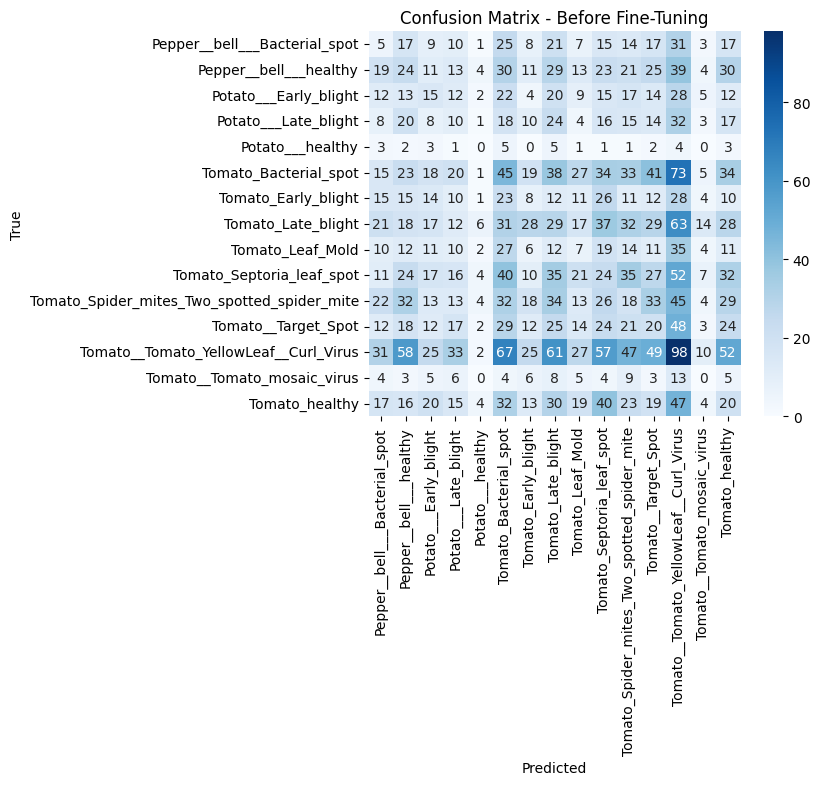

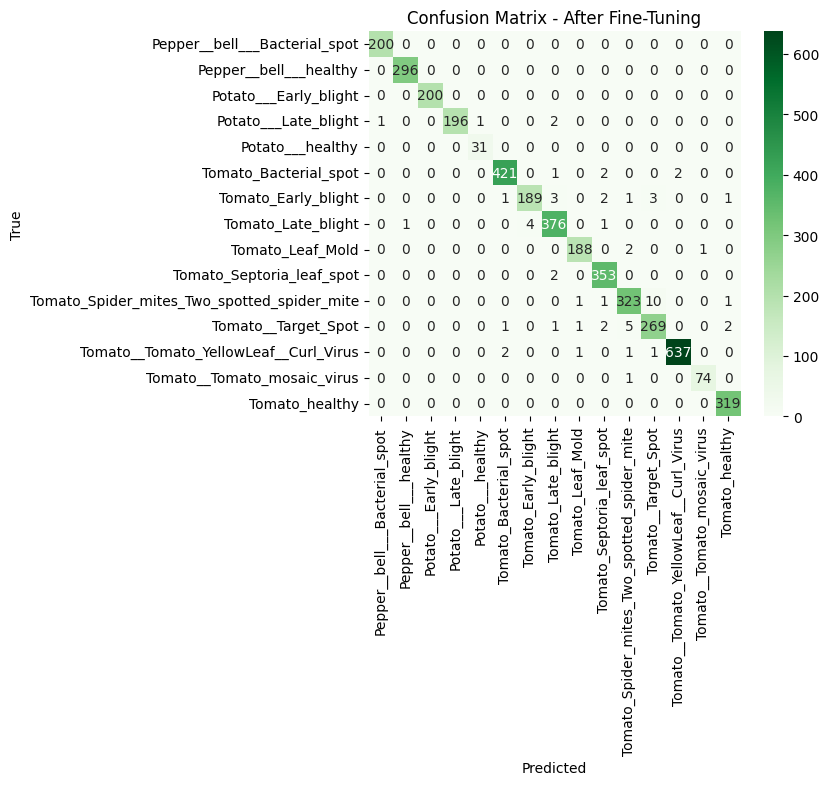

In [18]:
true_labels = val_image_generator.classes

pred_before_classes = np.argmax(pred_before, axis=1)
pred_after_classes = np.argmax(pred_after, axis=1)

cm_before = confusion_matrix(true_labels, pred_before_classes)
cm_after = confusion_matrix(true_labels, pred_after_classes)

plt.figure(figsize=(12, 5))

# ---------- FIGURE 1 (Before) ----------
plt.figure(figsize=(6, 5))
sns.heatmap(cm_before, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Before Fine-Tuning")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------- FIGURE 2 (After) ----------
plt.figure(figsize=(6, 5))
sns.heatmap(cm_after, annot=True, fmt="d", cmap="Greens",
             xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - After Fine-Tuning")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



<div style="background-color:#3CB371; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:15px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h3 style="margin:0; font-size:20px;">8.b) Classification Report</h3>
    <p style="color:white; font-size:15px; margin-top:5px; line-height:1.4;">
        The classification report summarizes the model’s performance on each plant disease class, both before and after fine-tuning.
        It provides metrics such as Precision, Recall, and F1-Score, which are crucial for understanding class-level performance.
    </p>
    <ul style="font-size:15px; line-height:1.5; color:white; margin-left:15px;">
        <li><strong>Precision</strong> — Proportion of correctly predicted instances among all predicted instances of a class.</li>
        <li><strong>Recall</strong> — Proportion of correctly predicted instances among all actual instances of a class.</li>
        <li><strong>F1-Score</strong> — Harmonic mean of Precision and Recall, giving a single metric for class performance.</li>
        <li><strong>Support</strong> — Number of true instances for each class in the dataset.</li>
    </ul>
    <p style="color:white; font-size:15px; margin-top:5px; line-height:1.4;">
        Comparing classification reports before and after fine-tuning helps identify which disease classes benefited most from fine-tuning and which classes still need improvement.
    </p>
</div>


In [19]:
# ---- Classification Report ----
report = classification_report(true_labels, pred_before_classes, target_names=class_names)
print("\nClassification Report Before Fine-Tuning :")
print(report)


Classification Report Before Fine-Tuning :
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.02      0.03      0.02       200
                     Pepper__bell___healthy       0.08      0.08      0.08       296
                      Potato___Early_blight       0.08      0.07      0.08       200
                       Potato___Late_blight       0.05      0.05      0.05       200
                           Potato___healthy       0.00      0.00      0.00        31
                      Tomato_Bacterial_spot       0.10      0.11      0.11       426
                        Tomato_Early_blight       0.04      0.04      0.04       200
                         Tomato_Late_blight       0.08      0.08      0.08       382
                           Tomato_Leaf_Mold       0.04      0.04      0.04       191
                  Tomato_Septoria_leaf_spot       0.07      0.07      0.07       355
Tomato_Spider_mites_

In [20]:
# ---- Classification Report ----
report = classification_report(true_labels, pred_after_classes, target_names=class_names)
print("\nClassification Report After Fine-Tuning :")
print(report)


Classification Report After Fine-Tuning :
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       200
                     Pepper__bell___healthy       1.00      1.00      1.00       296
                      Potato___Early_blight       1.00      1.00      1.00       200
                       Potato___Late_blight       1.00      0.98      0.99       200
                           Potato___healthy       0.97      1.00      0.98        31
                      Tomato_Bacterial_spot       0.99      0.99      0.99       426
                        Tomato_Early_blight       0.98      0.94      0.96       200
                         Tomato_Late_blight       0.98      0.98      0.98       382
                           Tomato_Leaf_Mold       0.98      0.98      0.98       191
                  Tomato_Septoria_leaf_spot       0.98      0.99      0.99       355
Tomato_Spider_mites_T

<div style="background-color:#3CB371; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:15px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h3 style="margin:0; font-size:20px;">8.c) Training Curves (Loss & Accuracy)</h3>
    <p style="color:white; font-size:15px; margin-top:5px; line-height:1.4;">
        The training curves visualize how the model’s loss and accuracy evolved over each epoch for both training and validation sets. 
        This helps to assess learning behavior and detect issues like overfitting or underfitting.
    </p>
    <ul style="font-size:15px; line-height:1.5; color:white; margin-left:15px;">
        <li><strong>Training Loss</strong> — Shows the decrease of loss on the training set.</li>
        <li><strong>Validation Loss</strong> — Indicates how well the model generalizes to unseen data.</li>
        <li><strong>Training Accuracy</strong> — Progression of correctly predicted samples during training.</li>
        <li><strong>Validation Accuracy</strong> — How accurately the model performs on validation data.</li>
    </ul>
    <p style="color:white; font-size:15px; margin-top:5px; line-height:1.4;">
        By examining these curves, we can understand the impact of fine-tuning on model performance and stability over epochs.
    </p>
</div>


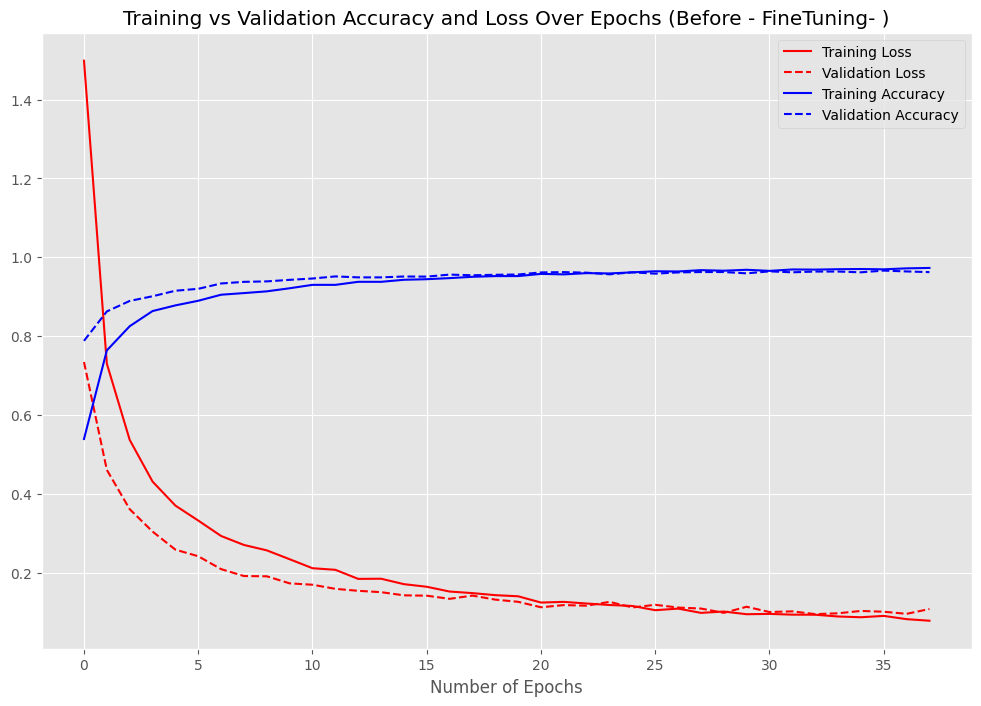

In [21]:
# Get the training history
h = hist.history

# Set plotting style
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
plt.title("Training vs Validation Accuracy and Loss Over Epochs (Before - FineTuning- )")

# Plot training and validation loss
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')

# Plot training and validation accuracy
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')

plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

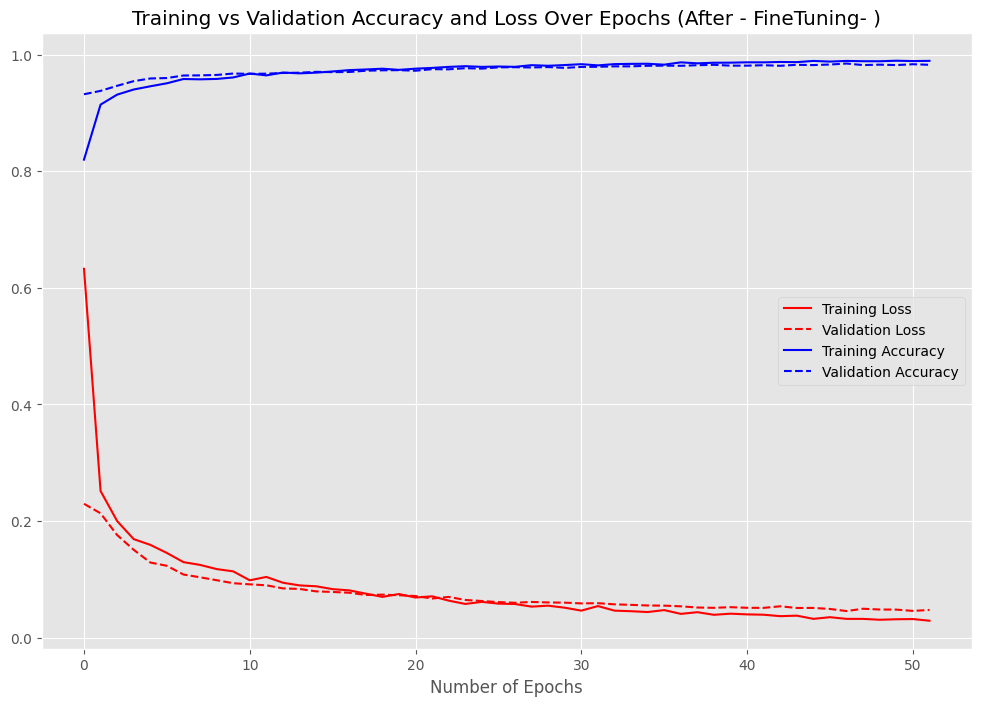

In [22]:
# Get the training history
h = fine_tune_history.history

# Set plotting style
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
plt.title("Training vs Validation Accuracy and Loss Over Epochs (After - FineTuning- )")


# Plot training and validation loss
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')

# Plot training and validation accuracy
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')

plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

<div style="background-color:#2E8B57; color:white; padding:10px 20px; border-radius:8px; font-family: 'Arial', sans-serif; margin-top:20px; margin-bottom:10px; box-shadow: 0 3px 6px rgba(0,0,0,0.1);">
    <h2 style="margin:0; font-size:24px;">9) Testing Images from Google</h2>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        To further evaluate the model's generalization capabilities, additional plant disease images were collected from Google and used as test samples.
        This step ensures the model is robust and can handle real-world images beyond the training dataset.
    </p>
    <ul style="font-size:16px; line-height:1.5; color:white; margin-left:15px;">
        <li><strong>Image Selection</strong> — Relevant images for each plant disease category were carefully selected to match dataset conditions.</li>
        <li><strong>Preprocessing</strong> — All images were resized, normalized, and preprocessed similarly to the training data for consistency.</li>
        <li><strong>Model Evaluation</strong> — Predictions were generated for these images and compared to actual disease labels to assess real-world performance.</li>
    </ul>
    <p style="color:white; font-size:16px; margin-top:5px; line-height:1.4;">
        Testing on external images provides insights into the model’s robustness, highlights potential limitations, and confirms whether fine-tuning improvements translate to unseen, real-world data.
    </p>
</div>


In [23]:
def PredictImageFromPath(image_path,actual):

     # Load and preprocess the image
    img = load_img(image_path, target_size=(WIDTH,HEIGHT))
    img_array = preprocess_input(img_to_array(img))
    img_array_exp = np.expand_dims(img_array, axis=0) # Add batch dimension

    # Make prediction
    pred = model_after.predict(img_array_exp, verbose=0)
    class_index = np.argmax(pred, axis=1)[0]
    label = class_names[class_index]    

    # Display the image with predicted label
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Predicted: {label} \n Actual: {actual}")
    plt.axis('off')
    plt.show()
    

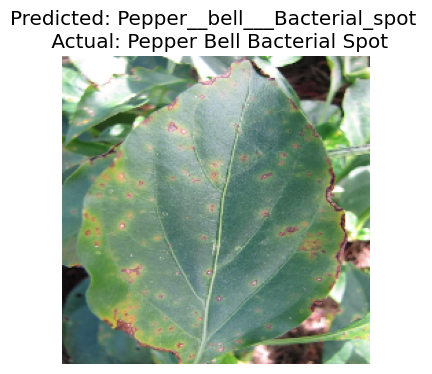

In [24]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/bacterial pepper/Pepper-Bacterial-Leaf-Spot-Leaf.jpg","Pepper Bell Bacterial Spot")


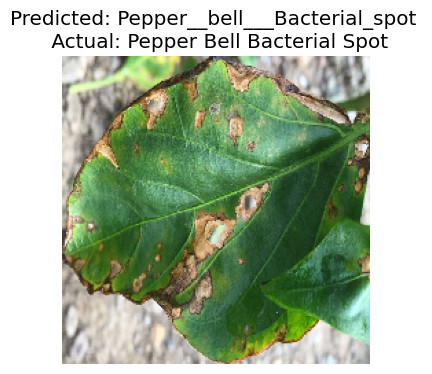

In [25]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/bacterial pepper/figure-2-tattered appearance on the affected leaves-893x595.jpg","Pepper Bell Bacterial Spot")


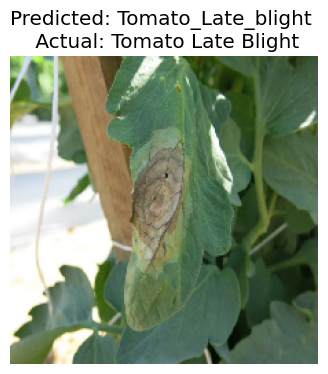

In [26]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/Tomato Late blight/IMG_5813.jpg","Tomato Late Blight")


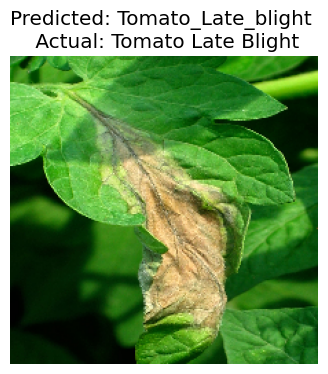

In [27]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/Tomato Late blight/late_blight_tomato_leaf5x12001-1.jpg","Tomato Late Blight")


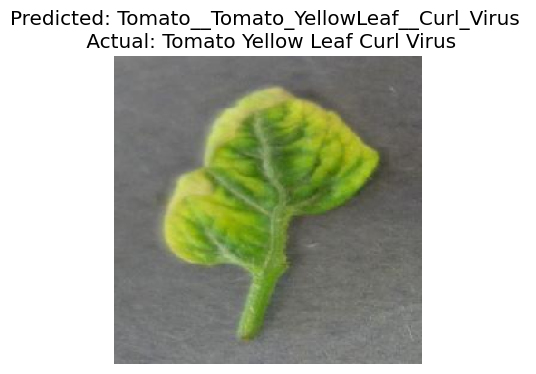

In [28]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/tomato yellow virus/original.jpg","Tomato Yellow Leaf Curl Virus")


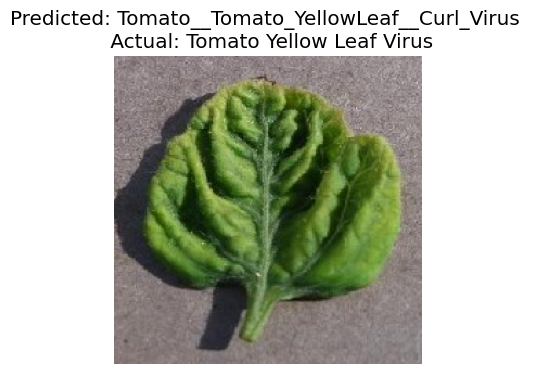

In [29]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/tomato yellow virus/thumb.jpg","Tomato Yellow Leaf Virus")


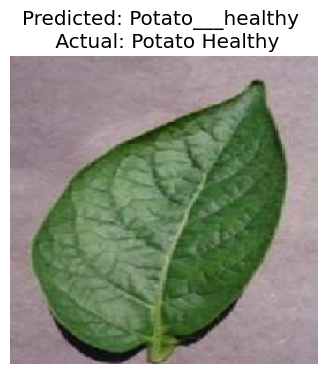

In [30]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/potato leaf healthy/The-three-Sample-leaves-of-potato-are-a-leaf-affected-by-Light-Blight-b-leaf.jpg","Potato Healthy")


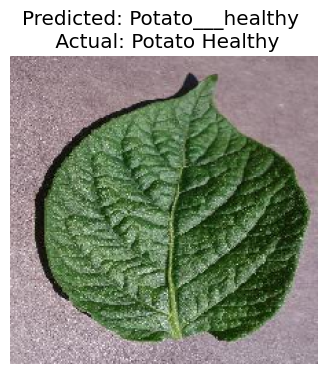

In [31]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/potato leaf healthy/original.jpg","Potato Healthy")


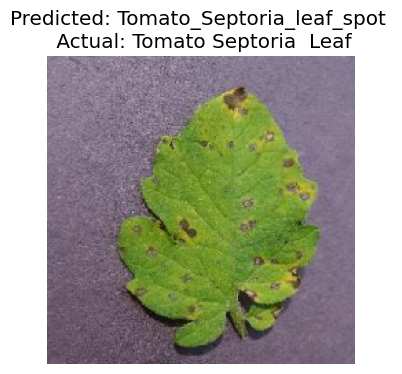

In [32]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/septoria leaf spot/A-tomato-leaf-with-Septoria-leaf-spot-which-is-a-fungal-disease.png","Tomato Septoria  Leaf")


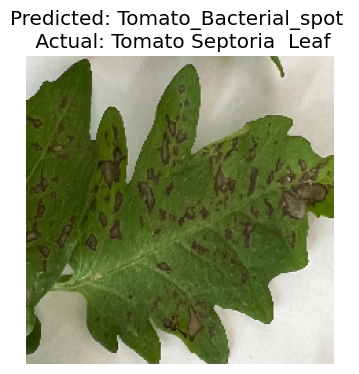

In [33]:
PredictImageFromPath("/kaggle/input/last-test-images/Test_Images/septoria leaf spot/tomato-septoria-leaf-spot-cropped.jpg","Tomato Septoria  Leaf")
